**Import libraries**


In [ ]:
import re
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from wordcloud import WordCloud
from gensim.utils import simple_preprocess
import gensim
from sklearn.model_selection import train_test_split
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
nltk.download('stopwords')
stopwords_english = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from keras.models import Sequential
from keras import layers 
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Model

from IPython.display import Image, clear_output

In [ ]:
def convert(integer):
    if (integer == 'positive'):
        return 1
    elif (integer == 'negative'):
        return -1
    elif (integer == 'neutral'):
        return 0

**Load Dataset (Load your dataset here)**

In [ ]:
df_sarcasm1 = pd.read_csv('/content/drive/MyDrive/FYP/Sarcasm_Headlines_Dataset_v2.csv')
df_sarcasm1 = df_sarcasm1.rename(columns={'headline': 'clean_comment', 'is_sarcastic':'label'})
df_sarcasm1 = df_sarcasm1[['label', 'clean_comment']]
df_sarcasm1

,label,clean_comment
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...
...,...,...
28614,1,jews to celebrate rosh hashasha or something
28615,1,internal affairs investigator disappointed con...
28616,0,the most beautiful acceptance speech this week...
28617,1,mars probe destroyed by orbiting spielberg-gat...


In [ ]:
df_sarcasm = pd.read_csv('/content/drive/MyDrive/FYP/sarcasm data/train_sarcasm.csv')
df_sarcasm = df_sarcasm[['label', 'tweet']]
df_sarcasm = df_sarcasm.rename(columns={'tweet': 'clean_comment'})
#df_sarcasm = df_sarcasm[['is_sarcastic', 'headline']]
df_sarcasm = pd.concat([df_sarcasm,df_sarcasm1])
df_sarcasm = df_sarcasm.dropna()
df_sarcasm

,label,clean_comment
0,1,It feels like just a few days ago it was the l...
1,1,"I love my mom . No matter what we go through ,..."
2,1,Bump that music ... #imtryingtosleep #sarcasm
3,0,Mexican and black jokes are pretty much the sa...
4,0,How to find work you love :
...,...,...
28614,1,jews to celebrate rosh hashasha or something
28615,1,internal affairs investigator disappointed con...
28616,0,the most beautiful acceptance speech this week...
28617,1,mars probe destroyed by orbiting spielberg-gat...


In [ ]:
reddit_data = pd.read_csv('/content/drive/MyDrive/FYP/test data/Reddit_Data.csv')
twitter_data = pd.read_csv('/content/drive/MyDrive/FYP/test data/Twitter_Data.csv')
twitter_data = twitter_data.rename(columns={'clean_text': 'clean_comment'})
df_sentiment = pd.concat([reddit_data,twitter_data])
df_sentiment = df_sentiment.rename(columns={'category': 'label'})
df_sentiment = df_sentiment.dropna()
df_sentiment

,clean_comment,label
0,family mormon have never tried explain them t...,1.0
1,buddhism has very much lot compatible with chr...,1.0
2,seriously don say thing first all they won get...,-1.0
3,what you have learned yours and only yours wha...,0.0
4,for your own benefit you may want read living ...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


In [ ]:
data_sentiment = pd.read_csv('/content/drive/MyDrive/FYP/train.csv')
data_sentiment = data_sentiment[['text.1', 'sentiment']]
data_sentiment = data_sentiment.rename(columns={'text.1': 'clean_comment'})
data_sentiment['clean_comment'].fillna('No content', inplace = True)
data_sentiment = data_sentiment.rename(columns={'sentiment': 'label'})
data_sentiment['label'] = data_sentiment['label'].apply(convert)
df_sentiment = pd.concat([df_sentiment,data_sentiment])
df_sentiment = df_sentiment.dropna()
df_sentiment

,clean_comment,label
0,family mormon have never tried explain them t...,1.0
1,buddhism has very much lot compatible with chr...,1.0
2,seriously don say thing first all they won get...,-1.0
3,what you have learned yours and only yours wha...,0.0
4,for your own benefit you may want read living ...,1.0
...,...,...
27477,d lost,-1.0
27478,", don`t force",-1.0
27479,Yay good for both of you.,1.0
27480,But it was worth it ****.,1.0


**Upsample dataset**

In [ ]:
# Separate majority and minority classes
data_majority = df_sentiment[df_sentiment['label'] == 1]
data_minority = df_sentiment[df_sentiment['label'] == -1]
data_minority2 = df_sentiment[df_sentiment['label'] == 0]

print(len(data_majority))
print(len(data_minority))
print(len(data_minority2))

bias = data_minority.shape[0]/data_majority.shape[0]
# lets split train/test data first then 
train = pd.concat([data_majority.sample(frac=1,random_state=200),
         data_minority.sample(frac=1,random_state=200),data_minority2.sample(frac=1,random_state=200)])
#test = pd.concat([data_majority.drop(data_majority.sample(frac=0.8,random_state=200).index),
       # data_minority.drop(data_minority.sample(frac=0.8,random_state=200).index)])

#train = shuffle(train)
#test = shuffle(test)

print('positive data in training:',(train.label == 1).sum())
print('negative data in training:',(train.label == -1).sum())
print('neutral data in training:',(train.label == 0).sum())
#print('positive data in test:',(test.label == 1).sum())
#print('negative data in test:',(test.label == 0).sum())

# Separate majority and minority classes in training data for upsampling 
data_majority = train[train['label'] == 1]
data_minority = train[train['label'] == -1]
data_minority2 = train[train['label'] == 0]

print("majority class before upsample:",data_majority.shape)
print("minority class before upsample:",data_minority.shape)
print("minority class2 before upsample:",data_minority2.shape)

# Upsample minority class
data_minority_upsampled = resample(data_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples= data_majority.shape[0],    # to match majority class
                                 random_state=123) # reproducible results
data_minority_upsampled2 = resample(data_minority2, 
                                 replace=True,     # sample with replacement
                                 n_samples= data_majority.shape[0],    # to match majority class
                                 random_state=123) # reproducible results
# Combine majority class with upsampled minority class
data_upsampled_sentiment = pd.concat([data_majority, data_minority_upsampled, data_minority_upsampled2])
 
# Display new class counts
print("After upsampling\n",data_upsampled_sentiment.label.value_counts(),sep = "")


96662
51567
79371
positive data in training: 96662
negative data in training: 51567
neutral data in training: 79371
majority class before upsample: (96662, 2)
minority class before upsample: (51567, 2)
minority class2 before upsample: (79371, 2)
After upsampling
-1.0    96662
 0.0    96662
 1.0    96662
Name: label, dtype: int64


In [ ]:
# Separate majority and minority classes
data_majority = df_sarcasm[df_sarcasm['label'] == 0]
data_minority = df_sarcasm[df_sarcasm['label'] == 1]

print(len(data_majority))
print(len(data_minority))

bias = data_minority.shape[0]/data_majority.shape[0]
# lets split train/test data first then 
train = pd.concat([data_majority.sample(frac=1,random_state=200),
         data_minority.sample(frac=1,random_state=200)])
#test = pd.concat([data_majority.drop(data_majority.sample(frac=0.8,random_state=200).index),
       # data_minority.drop(data_minority.sample(frac=0.8,random_state=200).index)])

#train = shuffle(train)
#test = shuffle(test)

print('Not sarcastic data in training:',(train.label == 0).sum())
print('sarcastic data in training:',(train.label == 1).sum())
#print('positive data in test:',(test.label == 1).sum())
#print('negative data in test:',(test.label == 0).sum())

# Separate majority and minority classes in training data for upsampling 
data_majority = train[train['label'] == 0]
data_minority = train[train['label'] == 1]


print("majority class before upsample:",data_majority.shape)
print("minority class before upsample:",data_minority.shape)

# Upsample minority class
data_minority_upsampled = resample(data_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples= data_majority.shape[0],    # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
data_upsampled_sarcasm = pd.concat([data_majority, data_minority_upsampled])
 
# Display new class counts
print("After upsampling\n",data_upsampled_sarcasm.label.value_counts(),sep = "")


27326
23396
Not sarcastic data in training: 27326
sarcastic data in training: 23396
majority class before upsample: (27326, 2)
minority class before upsample: (23396, 2)
After upsampling
1    27326
0    27326
Name: label, dtype: int64


**Visualize Data**

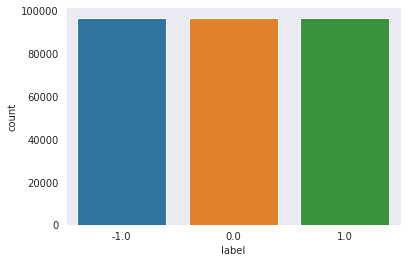

In [ ]:
sns.set_style("dark")
#sns.countplot(df_sarcasm.is_sarcastic)
sns.countplot(data_upsampled_sentiment.label)

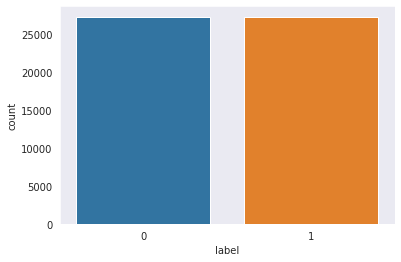

In [ ]:
sns.set_style("dark")
sns.countplot(data_upsampled_sarcasm.label)

**Data Pre-process**

In [ ]:

def depure_data(data):
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data

def sent_to_words(sentences):
    for sentence in sentences:
        yield gensim.utils.simple_preprocess(str(sentence), deacc=True)  # deacc=True removes punctuations

def preprocess(tweet, remove_stopwords=True, lemmatize=True):
    temp = [] 
    # Splitting pd.Series to list
    data_to_list = tweet['clean_comment'].values.tolist()
    for i in range(len(data_to_list)):
        temp.append(depure_data(data_to_list[i]))  
    data_words = list(sent_to_words(temp))
    # Remove stopwords
    if remove_stopwords:
        data_words = [[word for word in doc if word not in gensim.parsing.preprocessing.STOPWORDS] for doc in data_words]
    
    # Lemmatize words
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        data_words = [[lemmatizer.lemmatize(word) for word in doc] for doc in data_words]
        
    data = []
    for i in range(len(data_words)):
        data.append(TreebankWordDetokenizer().detokenize(data_words[i]))
    del data_words, temp, i
    return data


In [ ]:
sarcasm_data = preprocess(data_upsampled_sarcasm)
sentiment_data = preprocess(data_upsampled_sentiment)

**Tokenize word**

In [ ]:
max_words = 5000
max_len = 200

data_sentiment = sentiment_data
tokenizer_sentiment = Tokenizer(num_words=max_words)
tokenizer_sentiment.fit_on_texts(data_sentiment)
sequences_sentiment = tokenizer_sentiment.texts_to_sequences(data_sentiment)
tweets_sentiment = pad_sequences(sequences_sentiment, maxlen=max_len)


data_sarcasm = sarcasm_data
tokenizer_sarcasm = Tokenizer(num_words=max_words)
tokenizer_sarcasm.fit_on_texts(data_sarcasm)
sequences_sarcasm = tokenizer_sarcasm.texts_to_sequences(data_sarcasm)
tweets_sarcasm = pad_sequences(sequences_sarcasm, maxlen=max_len)

tweets_sentiment, tweets_sarcasm

(array([[   0,    0,    0, ...,  137, 1201, 3132],
        [   0,    0,    0, ...,    3,   58,  688],
        [   0,    0,    0, ...,   65,   40,    2],
        ...,
        [   0,    0,    0, ...,  285,    7,  807],
        [   0,    0,    0, ...,    2,  241,  241],
        [   0,    0,    0, ...,    1,  680,  614]], dtype=int32),
 array([[   0,    0,    0, ...,  223, 2076,    9],
        [   0,    0,    0, ...,    6, 3705, 2119],
        [   0,    0,    0, ..., 1187,    8,  177],
        ...,
        [   0,    0,    0, ...,   65,   32,  117],
        [   0,    0,    0, ...,  121,   24,  136],
        [   0,    0,    0, ...,  300,   19,   77]], dtype=int32))

**Label encoding**

In [ ]:
labels_sarcasm  = data_upsampled_sarcasm[['label']].values
len(labels_sarcasm), len(tweets_sarcasm)

(54652, 54652)

In [ ]:
#Label encoding

labels_sentiment = np.array(data_upsampled_sentiment['label'])
y = []
for i in range(len(labels_sentiment)):
    if labels_sentiment[i] == 0:
        y.append(0)
    if labels_sentiment[i] == -1:
        y.append(1)
    if labels_sentiment[i] == 1:
        y.append(2)
y = np.array(y)
print(y)
labels_sentiment = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y
len(labels_sentiment)

[2 2 2 ... 0 0 0]


289986

**Train_test_split**

In [ ]:
#Splitting the data
X_train_sarcasm, X_test_sarcasm, y_train_sarcasm, y_test_sarcasm = train_test_split(tweets_sarcasm,labels_sarcasm, test_size=0.1,random_state=1, shuffle = True)
print (len(X_train_sarcasm),len(X_test_sarcasm),len(y_train_sarcasm),len(y_test_sarcasm))

X_train_sentiment, X_test_sentiment, y_train_sentiment, y_test_sentiment = train_test_split(tweets_sentiment,labels_sentiment, test_size=0.1,random_state=1, shuffle = True)
print (len(X_train_sentiment),len(X_test_sentiment),len(y_train_sentiment),len(y_test_sentiment))

49186 5466 49186 5466
260987 28999 260987 28999


In [ ]:
EMBEDDING_FILE = '/content/drive/MyDrive/FYP/glove.twitter.27B.200d.txt'
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding = 'utf8'))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

#tokenizer = Tokenizer(num_words=max_words)
word_index = tokenizer_sentiment.word_index
nb_words = min(max_words, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix_sentiment = embedding_matrix_sentiment = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_words: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix_sentiment[i-1] = embedding_vector

In [ ]:
# EMBEDDING_FILE = '/content/drive/MyDrive/FYP/glove.twitter.27B.200d.txt'
# def get_coefs(word, *arr): 
#     return word, np.asarray(arr, dtype='float32')
# embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding = 'utf8'))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

#tokenizer = Tokenizer(num_words=max_words)
word_index = tokenizer_sarcasm.word_index
nb_words = min(max_words, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix_sarcasm = embedding_matrix_sarcasm = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_words: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix_sarcasm[i-1] = embedding_vector

**Machine Learning Algorithm**

In [ ]:
embedding_layer1 = layers.Embedding(nb_words, output_dim=200, input_length=max_len, weights = [embedding_matrix_sentiment], trainable = True)
embedding_layer2 = layers.Embedding(nb_words, output_dim=200, input_length=max_len, weights = [embedding_matrix_sarcasm], trainable = True)
#embedding_layer = layers.Embedding(max_words, output_dim=200, input_length=max_len)
sequence_input1 = layers.Input(shape=(max_len,), name='sentiment_input')
sequence_input2 = layers.Input(shape=(max_len,), name='sarcasm_input')
embedded_sequences1 = embedding_layer1(sequence_input1)
embedded_sequences2 = embedding_layer2(sequence_input2)

#sentiment branch
nn1 = layers.Bidirectional(layers.LSTM(units=20 , dropout = 0.6))(embedded_sequences1)
nn1 = layers.Dense(256, activation="relu")(nn1)
nn1 = layers.Dropout(rate=0.4)(nn1)
nn1 = layers.Dense(32, activation="relu")(nn1)
nn1 = layers.Dropout(rate=0.4)(nn1)

#sarcasm branch
nn2 = layers.Bidirectional(layers.LSTM(units=20 ,dropout = 0.6))(embedded_sequences2)
nn2 = layers.Dense(256, activation="relu")(nn2)
nn2 = layers.Dropout(rate=0.4)(nn2)
nn2 = layers.Dense(32, activation="relu")(nn2)
nn2 = layers.Dropout(rate=0.4)(nn2)

In [ ]:
sentiment_branch = layers.Dense(3, activation='softmax', name='sentiment_output')(nn1)
sarcasm_branch = layers.Dense(1, activation='sigmoid', name='sarcasm_output')(nn2)

In [ ]:
model = Model(inputs = [sequence_input1, sequence_input2], outputs = [sentiment_branch, sarcasm_branch])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentiment_input (InputLayer)    [(None, 200)]        0                                            
__________________________________________________________________________________________________
sarcasm_input (InputLayer)      [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 200)     1000000     sentiment_input[0][0]            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 200)     1000000     sarcasm_input[0][0]              
______________________________________________________________________________________________

In [ ]:
opt = keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=opt, loss={'sentiment_output':'categorical_crossentropy','sarcasm_output':'binary_crossentropy'}, metrics=['acc'])
checkpoint2 = [ModelCheckpoint("/content/drive/MyDrive/FYP/weights/with_embedding(LSTM)1.hdf5", monitor='val_sentiment_output_acc', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)]

In [ ]:
class PlotProgress(keras.callbacks.Callback):
    
    def __init__(self, entity='loss'):
        self.entity = entity
        
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('{}'.format(self.entity)))
        self.val_losses.append(logs.get('val_{}'.format(self.entity)))
        self.i += 1
        
        clear_output(wait=True)
        fig = plt.figure()
        plt.plot(self.x, self.losses, label= 'training_loss', color = 'Black')
        plt.plot(self.x, self.val_losses, label= 'validation_loss', ls = ':', color = 'Black')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        fig.patch.set_facecolor('white')
        
        #fig.patch.set_alpha(0.0)
        plt.grid()
        plt.legend()
        plt.show();

In [ ]:
plot_progress = PlotProgress(entity='loss')

try:
    model.fit({'sentiment_input': X_train_sentiment,'sarcasm_input':X_train_sarcasm},
              {'sentiment_output': y_train_sentiment, 'sarcasm_output': y_train_sarcasm},
              epochs=50,
              batch_size=128,
              verbose=1,
              callbacks=[plot_progress, checkpoint2],
              validation_split=0.2,
             )
except KeyboardInterrupt:
    pass